# 【問題1】スクラッチを振り返る
ここまでのスクラッチを振り返り、ディープラーニングを実装するためにはどのようなものが必要だったかを列挙してください。

（例）  
* 重みを初期化する必要があった  
* エポックのループが必要だった 

<白須さん>
* 変数、パラメータの定義
-- tf.placehoder
* 目的関数の定義
* ニューラルネットワークの定義
* メソッドの確認



*　隠れ層が複数のモデルを構築するためにクラスで層の情報をまとめる必要があった。

それらがフレームワークにおいてはどのように実装されるかを今回覚えていきましょう。  

# 【問題2】スクラッチとTensorFlowの対応を考える
以下のサンプルコードを見て、先ほど列挙した「ディープラーニングを実装するために必要なもの」が  
TensorFlowではどう実装されているかを確認してください。

それを簡単に言葉でまとめてください。単純な一対一の対応であるとは限りません。

In [14]:
"""
TensorFlowで実装したニューラルネットワークを使いIrisデータセットを2値分類する
"""
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf

# データセットの読み込み
dataset_path ="datasets/Iris.csv"
df = pd.read_csv(dataset_path)
# データフレームから条件抽出
df = df[(df["Species"] == "Iris-versicolor")|(df["Species"] == "Iris-virginica")]
y = df["Species"]
X = df.loc[:, ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]]
y = np.array(y)
X = np.array(X)
# ラベルを数値に変換
y[y=='Iris-versicolor'] = 0
y[y=='Iris-virginica'] = 1
y = y.astype(np.int)[:, np.newaxis]

# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      学習データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 10, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self.X[p0:p1], self.y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]

# ハイパーパラメータの設定
learning_rate = 0.01
batch_size = 10
num_epochs = 10

n_hidden1 = 50
n_hidden2 = 100
n_input = X_train.shape[1]
n_samples = X_train.shape[0]
n_classes = 1

# 計算グラフに渡す引数の形を決める
X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None, n_classes])

# trainのミニバッチイテレータ
get_mini_batch_train = GetMiniBatch(X_train, y_train, batch_size=batch_size)

def example_net(x):
    """
    単純な3層ニューラルネットワーク
    """

    # 重みとバイアスの宣言
    weights = {
        'w1': tf.Variable(tf.random_normal([n_input, n_hidden1])),
        'w2': tf.Variable(tf.random_normal([n_hidden1, n_hidden2])),
        'w3': tf.Variable(tf.random_normal([n_hidden2, n_classes]))
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([n_hidden1])),
        'b2': tf.Variable(tf.random_normal([n_hidden2])),
        'b3': tf.Variable(tf.random_normal([n_classes]))
    }

    layer_1 = tf.add(tf.matmul(x, weights['w1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    layer_output = tf.matmul(layer_2, weights['w3']) + biases['b3'] # tf.addと+は等価である
    return layer_output

# ネットワーク構造の読み込み                               
logits = example_net(X)

# 目的関数
loss_op = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=Y, logits=logits))
# 最適化手法
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

# 推定結果
correct_pred = tf.equal(tf.sign(Y - 0.5), tf.sign(tf.sigmoid(logits) - 0.5))
# 指標値計算
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# variableの初期化
init = tf.global_variables_initializer()


# 計算グラフの実行
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(num_epochs):
        # エポックごとにループ
        total_batch = np.ceil(X_train.shape[0]/batch_size).astype(np.int)
        total_loss = 0
        total_acc = 0
        for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):
            # ミニバッチごとにループ
            sess.run(train_op, feed_dict={X: mini_batch_x, Y: mini_batch_y})
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: mini_batch_x, Y: mini_batch_y})
            total_loss += loss
            total_acc += acc
        total_loss /= n_samples
        total_acc /= n_samples
        val_loss, val_acc = sess.run([loss_op, accuracy], feed_dict={X: X_val, Y: y_val})
        print("Epoch {}, loss : {:.4f}, val_loss : {:.4f}, acc : {:.3f}, val_acc : {:.3f}".format(epoch, loss, val_loss, acc, val_acc))
    test_acc = sess.run(accuracy, feed_dict={X: X_test, Y: y_test})
    print("test_acc : {:.3f}".format(test_acc))

Epoch 0, loss : 5.8545, val_loss : 14.2928, acc : 0.750, val_acc : 0.375
Epoch 1, loss : 5.2289, val_loss : 13.2057, acc : 0.750, val_acc : 0.375
Epoch 2, loss : 10.4459, val_loss : 7.0227, acc : 0.500, val_acc : 0.688
Epoch 3, loss : 0.0000, val_loss : 1.9767, acc : 1.000, val_acc : 0.750
Epoch 4, loss : 0.0076, val_loss : 2.4601, acc : 1.000, val_acc : 0.812
Epoch 5, loss : 0.0000, val_loss : 0.6478, acc : 1.000, val_acc : 0.938
Epoch 6, loss : 0.0000, val_loss : 2.7985, acc : 1.000, val_acc : 0.812
Epoch 7, loss : 0.0000, val_loss : 1.4324, acc : 1.000, val_acc : 0.812
Epoch 8, loss : 0.0012, val_loss : 4.5965, acc : 1.000, val_acc : 0.750
Epoch 9, loss : 0.0026, val_loss : 5.7552, acc : 1.000, val_acc : 0.625
test_acc : 0.800


# 【問題3】3種類全ての目的変数を使用したIrisのモデルを作成
Iris Species  
サンプルコードと同じくこの中のtrain.csvを使用してください。目的変数はSpeciesに含まれる3種類全てを使います。  
2クラスの分類と3クラス以上の分類の違いを考慮してください。  
それがTensorFlowでどのように書き換えられるかを公式ドキュメントなどを参考に調べてください。  

In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf

# データセットの読み込み
dataset_path ="datasets/Iris.csv"
df = pd.read_csv(dataset_path)
df.iloc[:,5].value_counts()

Iris-versicolor    50
Iris-setosa        50
Iris-virginica     50
Name: Species, dtype: int64

In [22]:
# データフレームから条件抽出
y = df["Species"]
X = df.loc[:, ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]]
y = np.array(y)
X = np.array(X)
# ラベルを数値に変換
y[y=='Iris-setosa'] = 0
y[y=='Iris-versicolor'] = 1
y[y=='Iris-virginica'] = 2

#y = y.astype(np.int)[:, np.newaxis]　必要ないので失敗。


# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#########################
#ワンホットエンコーディングを実施
########################
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])

y_train = y_train_one_hot
y_test = y_test_one_hot 


# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [31]:
# ハイパーパラメータの設定
learning_rate = 0.01
batch_size = 10
num_epochs = 50

n_hidden1 = 50 #50→
n_hidden2 = 100 #100→
n_input = X_train.shape[1]
n_samples = X_train.shape[0]
n_classes = 3 #何列のデータかを表すという仮説

# 計算グラフに渡す引数の形を決める
X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None, n_classes])

# trainのミニバッチイテレータ
get_mini_batch_train = GetMiniBatch(X_train, y_train, batch_size=batch_size)

In [32]:
def example_net(x):
    """
    単純な3層ニューラルネットワーク
    """

    # 重みとバイアスの宣言
    weights = {
        'w1': tf.Variable(tf.random_normal([n_input, n_hidden1])),
        'w2': tf.Variable(tf.random_normal([n_hidden1, n_hidden2])),
        'w3': tf.Variable(tf.random_normal([n_hidden2, n_classes]))
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([n_hidden1])),
        'b2': tf.Variable(tf.random_normal([n_hidden2])),
        'b3': tf.Variable(tf.random_normal([n_classes]))
    }

    layer_1 = tf.add(tf.matmul(x, weights['w1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    layer_output = tf.matmul(layer_2, weights['w3']) + biases['b3'] # tf.addと+は等価である
    return layer_output

In [33]:
# ネットワーク構造の読み込み                               
logits = example_net(X)

# 目的関数 ソフトマックスに変形
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=Y, logits=logits))

# 目的関数　２値分類のまま
#loss_op = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=Y, logits=logits))

# 最適化手法
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

# 推定結果 #ソフトマックス関数用に書き換え
correct_pred = tf.equal(tf.argmax(Y), tf.argmax(tf.nn.softmax(logits)))

# 指標値計算
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
                        
# variableの初期化
init = tf.global_variables_initializer()

In [34]:
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(num_epochs):
        # エポックごとにループ
        total_batch = np.ceil(X_train.shape[0]/batch_size).astype(np.int)
        total_loss = 0
        total_acc = 0
        for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):
            # ミニバッチごとにループ
            sess.run(train_op, feed_dict={X: mini_batch_x, Y: mini_batch_y})
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: mini_batch_x, Y: mini_batch_y})
            total_loss += loss
            total_acc += acc
        total_loss /= n_samples
        total_acc /= n_samples
        val_loss, val_acc = sess.run([loss_op, accuracy], feed_dict={X: X_val, Y: y_val})
        print("Epoch {}, loss : {:.4f}, val_loss : {:.4f}, acc : {:.3f}, val_acc : {:.3f}".format(epoch, loss, val_loss, acc, val_acc))
    test_acc = sess.run(accuracy, feed_dict={X: X_test, Y: y_test})
    print("test_acc : {:.3f}".format(test_acc))

Epoch 0, loss : 48.0882, val_loss : 125.7790, acc : 0.333, val_acc : 0.333
Epoch 1, loss : 14.5201, val_loss : 40.3705, acc : 0.333, val_acc : 0.333
Epoch 2, loss : 7.2523, val_loss : 1.1171, acc : 0.667, val_acc : 0.333
Epoch 3, loss : 0.0000, val_loss : 0.2873, acc : 1.000, val_acc : 0.667
Epoch 4, loss : 0.0000, val_loss : 1.7519, acc : 1.000, val_acc : 0.667
Epoch 5, loss : 0.0143, val_loss : 8.2238, acc : 1.000, val_acc : 0.333
Epoch 6, loss : 0.0000, val_loss : 0.5419, acc : 1.000, val_acc : 0.667
Epoch 7, loss : 0.0000, val_loss : 6.4781, acc : 1.000, val_acc : 0.667
Epoch 8, loss : 0.0000, val_loss : 1.4966, acc : 1.000, val_acc : 0.667
Epoch 9, loss : 0.0000, val_loss : 0.8048, acc : 1.000, val_acc : 1.000
Epoch 10, loss : 0.0000, val_loss : 4.1037, acc : 1.000, val_acc : 1.000
Epoch 11, loss : 0.3398, val_loss : 6.7229, acc : 1.000, val_acc : 0.667
Epoch 12, loss : 0.0000, val_loss : 6.2777, acc : 1.000, val_acc : 0.667
Epoch 13, loss : 0.0000, val_loss : 2.4892, acc : 1.000,

# 【問題4】House Pricesのモデルを作成
回帰問題のデータセットであるHouse Pricesを使用したモデルを作成してください。

House Prices: Advanced Regression Techniques

この中のtrain.csvをダウンロードし、目的変数としてSalePrice、説明変数として、GrLivAreaとYearBuiltを使ってください。説明変数はさらに増やしても構いません。

分類問題と回帰問題の違いを考慮してください。

In [168]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf

# データセットの読み込み
dataset_path_hp ="datasets/house_price_dataset_train.csv"
df_house_price = pd.read_csv(dataset_path_hp)

In [169]:
df_house_price.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [170]:
# データフレームから条件抽出
y = df_house_price["SalePrice"]
X = df_house_price.loc[:, ['GrLivArea','YearBuilt','LotArea']]
y = np.array(y)
X = np.array(X)
pd.DataFrame(y).head(10)

,0
0,208500
1,181500
2,223500
3,140000
4,250000
5,143000
6,307000
7,200000
8,129900
9,118000


In [171]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

class nnet:

    def __init__(self, X, random_state=3):
        self.sess = tf.Session()
        seed = random_state
        tf.set_random_seed(seed)
        np.random.seed(seed)
        self.x_data = tf.placeholder(shape=[None, X.shape[1]], dtype=tf.float32)
        self.y_target = tf.placeholder(shape=[None, 1], dtype=tf.float32)

    def init_weight(self, shape, st_dev):
        return tf.Variable(tf.random_normal(shape, stddev=st_dev))

    def init_bias(self, shape, st_dev):
        return tf.Variable(tf.random_normal(shape, stddev=st_dev))

    def fully_connected(self, input_layer, weights, biases):
        return tf.nn.relu(tf.add(tf.matmul(input_layer, weights), biases))

    def fit(self, X, y, hidden_size, batch_size=100, iter_size=200):

        x_data = self.x_data
        y_target = self.y_target

        final_output = self.build_hidden_layer(hidden_size, X.shape[1])

        self.loss = tf.reduce_mean(tf.abs(y_target - final_output))
        self.opt = tf.train.AdamOptimizer(0.01)
        self.train_step = self.opt.minimize(self.loss)

        init = tf.global_variables_initializer()
        self.sess.run(init)

        loss_vec = self.train(X, y, iter_size, batch_size)
        plt.plot(loss_vec)
        return final_output

    def predict(self, final_output, X):
        x_data = self.x_data
        return [val[0] for val in self.sess.run(final_output, feed_dict={x_data: X})]


    def train(self, X, y, iter_size, batch_size):
        loss_vec = []
        x_data = self.x_data
        y_target = self.y_target
        for i in range(iter_size):
            rand_index = np.random.choice(len(X), size=batch_size)
            rand_x = X[rand_index]
            rand_y = np.transpose([y[rand_index]])
            self.sess.run(self.train_step, feed_dict={x_data:rand_x, y_target: rand_y})
            loss_vec.append(self.sess.run(self.loss, feed_dict={x_data:rand_x, y_target: rand_y}))

            if (i+1)%25==0:
                print('Generation:'+str(i+1)+', Loss = '+str(loss_vec[-1]))

        return loss_vec


    def build_hidden_layer(self, hidden_size, col_size):
        weights = []
        biases = []
        layers = []
        tmp_size = col_size
        x_data = self.x_data
        last_layer = x_data

        for hsize in hidden_size:
            weights.append(self.init_weight(shape=[tmp_size, hsize], st_dev=10.0))
            biases.append(self.init_bias(shape=[hsize], st_dev=10.0))
            layers.append(self.fully_connected(last_layer, weights[-1], biases[-1]))
            tmp_size = hsize
            last_layer = layers[-1]

        weights.append(self.init_weight(shape=[tmp_size, 1], st_dev=10.0))
        biases.append(self.init_bias(shape=[1], st_dev=10.0))
        layers.append(self.fully_connected(last_layer, weights[-1], biases[-1]))
        final_output = layers[-1]

        return final_output

Generation:25, Loss = 128183.52
Generation:50, Loss = 101715.26
Generation:75, Loss = 71300.97
Generation:100, Loss = 75144.445
Generation:125, Loss = 61094.637
Generation:150, Loss = 57051.19
Generation:175, Loss = 64049.43
Generation:200, Loss = 57693.273
Generation:225, Loss = 49541.39
Generation:250, Loss = 67562.47
Generation:275, Loss = 52250.01
Generation:300, Loss = 53447.31
Generation:325, Loss = 49268.48
Generation:350, Loss = 53326.074
Generation:375, Loss = 49414.74
Generation:400, Loss = 47547.57
Generation:425, Loss = 46349.86
Generation:450, Loss = 55993.84
Generation:475, Loss = 45962.17
Generation:500, Loss = 47348.84
Generation:525, Loss = 45712.004
Generation:550, Loss = 42399.65
Generation:575, Loss = 43461.824
Generation:600, Loss = 40182.164
Generation:625, Loss = 44256.297
Generation:650, Loss = 47561.555
Generation:675, Loss = 36113.19
Generation:700, Loss = 37541.977
Generation:725, Loss = 38424.562
Generation:750, Loss = 47224.16
Generation:775, Loss = 37480.3

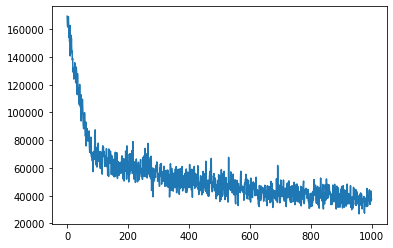

In [172]:
%matplotlib inline
nnetc = nnet(X)
model = nnetc.fit(X, y.ravel(), hidden_size=[2], iter_size=1000)

<予測結果>

In [173]:
predict_model = nnetc.predict(model,X)
pd.concat([pd.DataFrame(predict_model),pd.DataFrame(y)],axis=1).head(5)

,0,0
0,186098.562500,208500
1,153313.718750,181500
2,194508.625000,223500
3,185486.812500,140000
4,228097.453125,250000


# 【問題5】MNISTのモデルを作成
ニューラルネットワークのスクラッチで使用したMNISTを分類するモデルを作成してください。

3クラス以上の分類という点ではひとつ前のIrisと同様です。入力が画像であるという点で異なります。

スクラッチで実装したモデルの再現を目指してください。

In [245]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf

# データセットの読み込み

from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train =  X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)

In [246]:
#########################
#ワンホットエンコーディングを実施
########################
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])

y_train = y_train_one_hot
y_test = y_test_one_hot 


#########################
#　画像データの正規化
#########################
X_train = X_train / 255
X_test = X_test / 255

# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [247]:
# ハイパーパラメータの設定
learning_rate = 0.01
batch_size = 100
num_epochs = 10

n_hidden1 = 400 #50→
n_hidden2 = 200 #100→
n_input = X_train.shape[1]
n_samples = X_train.shape[0]
n_classes = 10 #何列のデータかを表すという仮説



# 計算グラフに渡す引数の形を決める
X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None, n_classes])

# trainのミニバッチイテレータ
get_mini_batch_train = GetMiniBatch(X_train, y_train, batch_size=batch_size)

In [248]:
def example_net(x):
    """
    単純な3層ニューラルネットワーク
    """

    # 重みとバイアスの宣言
    weights = {
        'w1': tf.Variable(tf.random_normal([n_input, n_hidden1])),
        'w2': tf.Variable(tf.random_normal([n_hidden1, n_hidden2])),
        'w3': tf.Variable(tf.random_normal([n_hidden2, n_classes]))
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([n_hidden1])),
        'b2': tf.Variable(tf.random_normal([n_hidden2])),
        'b3': tf.Variable(tf.random_normal([n_classes]))
    }

    layer_1 = tf.add(tf.matmul(x, weights['w1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    layer_output = tf.matmul(layer_2, weights['w3']) + biases['b3'] # tf.addと+は等価である
    return layer_output

In [249]:
# ネットワーク構造の読み込み                               
logits = example_net(X)

# 目的関数 ソフトマックスに変形
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=Y, logits=logits))


# 最適化手法
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

# 推定結果 #ソフトマックス関数用に書き換え
correct_pred = tf.equal(tf.argmax(Y), tf.argmax(tf.nn.softmax(logits)))

# 指標値計算
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
                        
# variableの初期化
init = tf.global_variables_initializer()

In [250]:
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(num_epochs):
        # エポックごとにループ
        total_batch = np.ceil(X_train.shape[0]/batch_size).astype(np.int)
        total_loss = 0
        total_acc = 0
        for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):
            # ミニバッチごとにループ
            sess.run(train_op, feed_dict={X: mini_batch_x, Y: mini_batch_y})
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: mini_batch_x, Y: mini_batch_y})
            total_loss += loss
            total_acc += acc
        total_loss /= n_samples
        total_acc /= n_samples
        val_loss, val_acc = sess.run([loss_op, accuracy], feed_dict={X: X_val, Y: y_val})
        print("Epoch {}, loss : {:.4f}, val_loss : {:.4f}, acc : {:.3f}, val_acc : {:.3f}".format(epoch, loss, val_loss, acc, val_acc))
    test_acc = sess.run(accuracy, feed_dict={X: X_test, Y: y_test})
    print("test_acc : {:.3f}".format(test_acc))

Epoch 0, loss : 13.1528, val_loss : 12.7131, acc : 0.800, val_acc : 0.800
Epoch 1, loss : 0.3920, val_loss : 8.9358, acc : 1.000, val_acc : 0.900
Epoch 2, loss : 0.8939, val_loss : 6.9012, acc : 0.900, val_acc : 0.900
Epoch 3, loss : 0.0367, val_loss : 6.6402, acc : 1.000, val_acc : 0.900
Epoch 4, loss : 0.3825, val_loss : 6.3165, acc : 1.000, val_acc : 0.800
Epoch 5, loss : 0.0000, val_loss : 5.9335, acc : 1.000, val_acc : 1.000
Epoch 6, loss : 1.1829, val_loss : 5.0616, acc : 1.000, val_acc : 0.900
Epoch 7, loss : 0.4174, val_loss : 6.5753, acc : 1.000, val_acc : 0.800
Epoch 8, loss : 0.0002, val_loss : 4.9376, acc : 1.000, val_acc : 1.000
Epoch 9, loss : 0.4715, val_loss : 4.7389, acc : 1.000, val_acc : 0.900
test_acc : 1.000
